RDKit Enumeration Toolkit 
=========================

RDKit Reaction Enumeration Toolkit tutorial.

Here you will learn how to enumerate reactions with various building blocks.

In [1]:
from __future__ import print_function
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.AllChem import ReactionFromRxnBlock, ReactionToRxnBlock
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

In [2]:
rxn_data = """$RXN

      ISIS     090220091539

  2  1
$MOL

  -ISIS-  09020915392D

  2  1  1  0  0  0  0  0  0  0999 V2000
   -2.0744    0.1939    0.0000 L   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5440   -0.1592    0.0000 R#  0  0  0  0  0  0  0  0  0  1  0  0
  1  2  1  0  0  0  0
  1 F    2  17  35
V    1 halogen
M  RGP  1   2   1
M  ALS   1  2 F Cl  Br   
M  END
$MOL

  -ISIS-  09020915392D

  2  1  0  0  0  0  0  0  0  0999 V2000
    2.8375   -0.2500    0.0000 R#  0  0  0  0  0  0  0  0  0  2  0  0
    3.3463    0.0438    0.0000 N   0  0  0  0  0  0  0  0  0  3  0  0
  1  2  1  0  0  0  0
V    2 amine.primary
M  RGP  1   1   2
M  END
$MOL

  -ISIS-  09020915392D

  3  2  0  0  0  0  0  0  0  0999 V2000
   13.5792    0.0292    0.0000 N   0  0  0  0  0  0  0  0  0  3  0  0
   14.0880    0.3229    0.0000 R#  0  0  0  0  0  0  0  0  0  1  0  0
   13.0704    0.3229    0.0000 R#  0  0  0  0  0  0  0  0  0  2  0  0
  1  2  1  0  0  0  0
  1  3  1  0  0  0  0
M  RGP  2   2   1   3   2
M  END"""

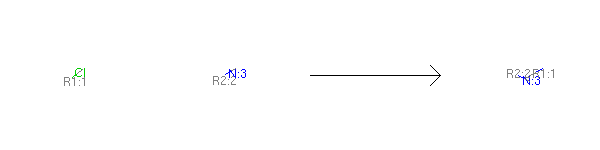

In [3]:
rxn = ReactionFromRxnBlock(rxn_data)
rxn

Sanitizing Reaction Blocks
==========================

Reaction blocks come from many different sketchers, and some don't follow the MDL conventions very well.  It is always a good idea to sanitize your reaction blocks first.  This is also true for Smiles reactions if they are in kekule form.

In [4]:
AllChem.SanitizeRxn(rxn)

rdkit.Chem.rdChemReactions.SanitizeFlags.SANITIZE_NONE

Preprocessing Reaction Blocks
=============================

You will note that there are some special annotations in the reaction block:
    
    V   1 halogen
    V   2 amine.primary
    
These allows us to specify functional groups with very specific smarts patterns.  
These smarts patterns are preloaded into the RDKit, but require the use of PreprocessReactions
to embed the patterns.

In [5]:
rxn.Initialize()
nWarn, nError, nReactants, nProducts, labels =  AllChem.PreprocessReaction(rxn)
print ("Number of warnings:", nWarn)
print ("Number of preprocessing errors:", nError)
print ("Number of reactants in reaction:", nReactants)
print ("Number of products in reaction:", nProducts)
print ("Preprocess labels added:", labels)

Number of warnings: 0
Number of preprocessing errors: 0
Number of reactants in reaction: 2
Number of products in reaction: 1
Preprocess labels added: (((0, 'halogen'),), ((1, 'amine.primary'),))


So now, this scaffold will only match the specified halogens and a primary amine.  Let's get some!

In [6]:
!wget http://www.sigmaaldrich.com/content/dam/sigma-aldrich/docs/Aldrich/General_Information/1/sdf-benzylic-primary-amines.sdf -O amines.sdf

--2016-11-05 09:31:09--  http://www.sigmaaldrich.com/content/dam/sigma-aldrich/docs/Aldrich/General_Information/1/sdf-benzylic-primary-amines.sdf
Resolving usca-proxy01.na.novartis.net... 160.62.237.221
Connecting to usca-proxy01.na.novartis.net|160.62.237.221|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 165130 (161K) [chemical/x-mdl-sdfile]
Saving to: 'amines.sdf'

amines.sdf          100%[=====================>] 161.26K   759KB/s   in 0.2s   

2016-11-05 09:31:09 (759 KB/s) - 'amines.sdf' saved [165130/165130]



In [7]:
!wget http://www.sigmaaldrich.com/content/dam/sigma-aldrich/docs/Aldrich/General_Information/1/sdf-alkyl-halides.sdf -O halides.sdf

--2016-11-05 09:31:09--  http://www.sigmaaldrich.com/content/dam/sigma-aldrich/docs/Aldrich/General_Information/1/sdf-alkyl-halides.sdf
Resolving usca-proxy01.na.novartis.net... 160.62.237.221
Connecting to usca-proxy01.na.novartis.net|160.62.237.221|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 149722 (146K) [chemical/x-mdl-sdfile]
Saving to: 'halides.sdf'

halides.sdf         100%[=====================>] 146.21K   634KB/s   in 0.2s   

2016-11-05 09:31:10 (634 KB/s) - 'halides.sdf' saved [149722/149722]



In [8]:
reagents = [
            [x for x in AllChem.SDMolSupplier("halides.sdf")],
            [x for x in AllChem.SDMolSupplier("amines.sdf")]
        ]

In [9]:
print ("number of reagents per template:", [len(x) for x in reagents])

number of reagents per template: [149, 131]


Basic Usage
===========

Creating a library for enumeration
----------------------------------

Using the enumerator is simple, simply supply the desired reaction and reagents.  The library filters away non-matching reagents by default.  The RDKit will log any removed reagents to the info log.

In [10]:
library = rdChemReactions.EnumerateLibrary(rxn, reagents)

RDKit INFO: [09:31:10] Removed 37 non matching reagents at template 0


If you only want each reactant to match once ( and hence only produce one product per reactant set ) you can adjust the parameters:

In [11]:
params = rdChemReactions.EnumerationParams()
params.reagentMaxMatchCount = 1
library = rdChemReactions.EnumerateLibrary(rxn, reagents, params=params)

RDKit INFO: [09:31:10] Removed 38 non matching reagents at template 0
RDKit INFO: [09:31:10] Removed 11 non matching reagents at template 1


Enumerating the library
-----------------------

A library has an enumerator that determines what reagents are selected for purposes of enumeration.
The default enumerator is a CartesianProduct enumerator, which is a fancy way of saying enumerate everything.  You can get hold this enumerator by using the **GetEnumerator** method.

In [12]:
enumerator = library.GetEnumerator()
print (enumerator)

In [13]:
print ("Possible number of permutations:", enumerator.GetNumPermutations())

Possible number of permutations: 13320


Understanding results of enumerations
-------------------------------------

Each enumeration result may contain multiple resulting molecules.  Consider a reaction setup as follows:

  A + B >> C + D
  
There may be multiple result molecules for a number of reasons:

  1. The reactant templates (A and B) match a reagent multiple times.
     Each match has to analyzed to form a new product.  Hence,
     the result has to be a vector of products.
  2. There me be multiple product templates, i.e. C+D as shown above
     where C and D are two different result templates.  These are
     output in a result as follows:
     
         result = enumerator.next()
         
         result == [ [results_from_product_template1], 
                     [results_from_product_template2], ... ]
           
         result[0] == [results_from_product_template1]
         result[1] == [results_from_Product_template2]
         

     
Because there may be multiple product templates specified with
potentially multiple matches, iterating through the results to
get to the final molecules isa bit complicated and requires three loops.  Here we use:

  * **result** for the result of reacting one set of reagents
  * **productSet** for the products for a given product template
  * **mol** the actual product
  
In many reactions, this will result in a single molecule, but the
datastructures have to handle the full set of results:
   
```
   for result in enumerator:
      for productSet in results:
          for mol in productSet:
```

In [14]:
count = 0
totalMols = 0
for results in library:
    for productSet in results:
        for mol in productSet:
            totalMols += 1
    count += 1
print("Number of result sets", count)
print("Number of result molecules", totalMols)

Number of result sets 13320
Number of result molecules 13320


*Note: the productSet above may be empty if one of the current reagents did
not match the reaction!*

*Note: the number of permutations is not the same as the number of molecules.  There may be more or less depending on how many times the reagent matched the template, or if the reagent matched
at all.*

How does the enumerator work?
=============================

As mentioned, you can make a copy of the current enumeration scheme using the **GetEnumerator** method.  Lets make a copy of this enumerator by **copying** it using copy.copy(..), this makes a copy so we don't change the state of the Library.

In [15]:
import copy
enumerator = copy.copy(library.GetEnumerator())
print(enumerator)
test_enumerator = copy.copy(enumerator)

Let's play with this enumerator.

First: let's understand what the position means (this is the same as **library.GetPosition**)

In [16]:
list(test_enumerator.GetPosition())

[110L, 119L]

What this means is make the product from reagents[0][111] and reagents[1][130]

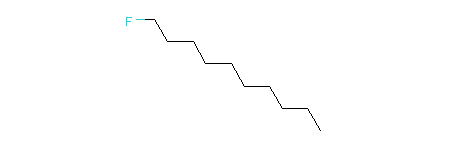

In [17]:
reagents[0][111]

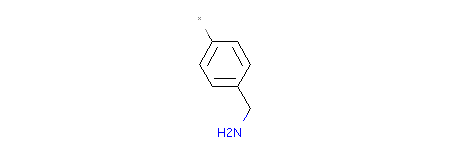

In [18]:
reagents[1][130]

This also appears to be the last product. So lets' start over.

In [19]:
library = rdChemReactions.EnumerateLibrary(rxn, reagents, params=params)
test_enumerator = copy.copy(library.GetEnumerator())
list(test_enumerator.GetPosition())

RDKit INFO: [09:31:11] Removed 38 non matching reagents at template 0
RDKit INFO: [09:31:11] Removed 11 non matching reagents at template 1


[0L, 0L]

We can Skip to the 100th result

In [20]:
test_enumerator.Skip(100)
pos = list(test_enumerator.GetPosition())
print(pos)

[99L, 0L]


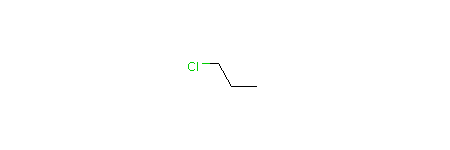

In [21]:
reagents[0][pos[0]]

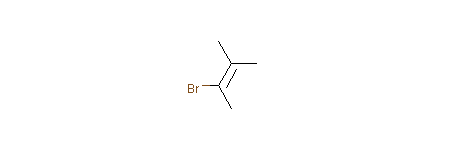

In [22]:
reagents[0][pos[1]]

Let's advance by one here and see what happens.  It's no surprise that for the CartesianProduct strategy the first index is increased by one.

In [23]:
pos = test_enumerator.next()
print(list(pos))

[100L, 0L]


Enumeration States
==================

Enumerations have states as well, so you can come back later using **GetState** and **SetState**

**GetState** returns a text string so you can save this pretty much anywhere you like.

Let's skip to the 100th sample and save both the state and the product at this step.

In [24]:
library = rdChemReactions.EnumerateLibrary(rxn, reagents, params=params)
# skip the first 100 molecules
library.GetEnumerator().Skip(100)
# get the state

state = library.GetState()
print("State is:\n", repr(state))

result = library.next()
for productSet in result:
    for mol in productSet:
        smiles = AllChem.MolToSmiles(mol)
        break

State is:
 '22 serialization::archive 12 0 1 1 31 RDKit::CartesianProductStrategy 1 1\n0 0 1 2 0 99 0 2 0 111 120 13320 100\n'


RDKit INFO: [09:31:11] Removed 38 non matching reagents at template 0
RDKit INFO: [09:31:11] Removed 11 non matching reagents at template 1


Now when we go back to this state, the next molecule should be the one we just saved.

In [25]:
library.SetState(state)
result = library.next()
for productSet in result:
    for mol in productSet:
        assert AllChem.MolToSmiles(mol) == smiles
        print(AllChem.MolToSmiles(mol), "==", smiles, "!")

CCNCc1cccc(c1)B1OC(C)(C)C(C)(C)O1 == CCNCc1cccc(c1)B1OC(C)(C)C(C)(C)O1 !


Resetting the enumeration back to the beginning
===============================================

To go back to the beginning, use **Reset**, for a CartesianProductStrategy this should revert back to [0,0] for indexing these reagents.

This is useful because the state of the library is saved when the library
is serialized.  See **Pickling Libraries** below.

In [26]:
library.ResetState()
print(list(library.GetPosition()))

[0L, 0L]


Pickling Libraries
==================

The whole library, including all reagents and the current enumeration state reagents is saved when the library is serialized.

In [27]:
s = library.Serialize() # XXX bug need default arg

In [28]:
library2 = rdChemReactions.EnumerateLibrary()
library2.InitFromString(s)

And the libraries are in lock step.

In [29]:
for i in range(10):
    result = library.next()
    for productSet in result:
        for mol in productSet:
            print("Result library1", AllChem.MolToSmiles(mol))
    result = library2.next()
    for productSet in result:
        for mol in productSet:
            print("Result library2", AllChem.MolToSmiles(mol))        

Result library1 CC(C)=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CC(C)=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 C=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 C=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CC=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CC=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CC=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CC=C(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CCC(C)(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CCC(C)(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CC(C)(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CC(C)(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CCCCCCCCCCC(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CCCCCCCCCCC(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CCCCCC(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CCCCCC(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library1 CCCC(C)NCc1cccc(c1)B1OC(C)(C)C(C)(C)O1
Result library2 CCCC(C)NCc1cccc(c1)B1

*Note: Don't forget that the enumeration state can be saved independently and applied to a serialized library.  Note that you will need to be careful to ensure that the enumeration state actually came from the library you are applying it against!*

Additional Enumeration Strategies
==================================

*rdChemReactions.RandomSampleStrategy* - randomly sample from the building blocks

*rdChemReactions.RandomSampleAllBBsStrategy* - randomly sample, but force using all reagents

*rdChemReactions.EvenSamplePairs* - evenly sample pairs of building blocks (use only for generation of small libraries)